In [6]:
import os
import pickle
import yaml
import functools

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import ml_collections
from clu import checkpoint


from molnet import utils, train_state, train
from molnet.data import input_pipeline_online, input_pipeline_water
from molnet.models import create_model
from configs import root_dirs
from analyses import make_predictions

from typing import Tuple

In [2]:
workdir = "/u/79/kurkil1/unix/work/molnet/runs/bf16-augs-water-adam-1e-4-z10-gx5/"
#workdir = "/Users/kurkil1/work/molnet/runs/attention-adam-3e-4/"

In [4]:
def load_from_workdir(
    workdir: str,
    return_attention: bool
):
    # Load the model config
    with open(os.path.join(workdir, "config.yaml"), "rt") as f:
        config = yaml.unsafe_load(f)
    config = ml_collections.ConfigDict(config)
    config.root_dir = root_dirs.get_root_dir("water-bilayer-tf")
    config.model.return_attention_maps = return_attention

    print(config)

    # Create the model
    model = create_model(config.model)

    checkpoint_dir = os.path.join(workdir, "checkpoints")
    ckpt = checkpoint.Checkpoint(checkpoint_dir)

    apply_fn = model.apply
    tx = utils.create_optimizer(config)
    restored_state = ckpt.restore(state=None)['state']

    # Load the model state
    state = train_state.EvaluationState.create(
        apply_fn=apply_fn,
        params=restored_state['params'],
        batch_stats=restored_state['batch_stats'],
        tx=tx,
    )
    state = jax.tree_util.tree_map(jnp.asarray, state)

    return state, config

In [5]:
state, config = load_from_workdir(
    workdir=workdir,
    return_attention=True
)

batch_size: 16
cutout_probs:
- 0.5
- 0.3
- 0.1
- 0.05
- 0.05
dataset: water-bilayer-tf
debug: false
eval_every_steps: 2000
gaussian_factor: 5.0
interpolate_input_z: null
learning_rate: 0.0001
learning_rate_schedule: constant
learning_rate_schedule_kwargs:
  decay_steps: 50000
  init_value: 0.0001
  peak_value: 0.0002
  warmup_steps: 2000
log_every_steps: 100
loss_fn: mse
max_atoms: 54
max_shift_per_slice: 0.02
model:
  attention_activation: sigmoid
  attention_channels:
  - 16
  - 32
  - 64
  - 128
  - 128
  conv_activation: relu
  decoder_channels:
  - 256
  - 128
  - 64
  - 32
  - 16
  decoder_kernel_size:
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  dtype: bfloat16
  encoder_channels:
  - 16
  - 32
  - 64
  - 128
  - 256
  encoder_kernel_size:
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  model_name: Attention-UNet
  output_activati

2025-01-28 12:34:05.521314: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
rng = jax.random.PRNGKey(0)
datarng, rng = jax.random.split(rng)
config.train_molecules = (0, 80000)
config.val_molecules = (80000, 100000)
config.batch_size = 4
#config.max_shift_per_slice = 0.02

ds = input_pipeline_online.get_datasets(
    config
)['val']

batch = next(iter(ds))

for k, v in batch.items():
    print(k, v.shape)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 18085879115725111131


images (4, 128, 128, 10, 1)
xyz (4, 54, 5)
sw (4, 2, 3)
atom_map (4, 128, 128, 10, 5)


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 14015997285969731913
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 14462771483250533871
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing 

In [6]:
@jax.jit
def predict(
    state,
    batch,
):
    inputs, targets = batch['images'], batch['atom_map']
    preds, attention = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        inputs,
        training=False,
    )
    loss_by_image = jnp.mean(
        (preds - targets) ** 2,
        axis=(1, 2, 3, 4),
    )
    return inputs, targets, preds, attention, loss_by_image


In [7]:
inputs, targets, preds, attention, loss_by_image = predict(
    state,
    batch,
)

In [8]:
print(f"inputs: {inputs.shape}")
print(f"targets: {targets.shape}")
print(f"preds: {preds.shape}")
print(f"loss_by_image: {loss_by_image.shape}")
for att in attention:
    print(f"attention: {att.shape}")

inputs: (4, 128, 128, 10, 1)
targets: (4, 128, 128, 10, 5)
preds: (4, 128, 128, 10, 5)
loss_by_image: (4,)
attention: (4, 8, 8, 10, 1)
attention: (4, 16, 16, 10, 1)
attention: (4, 32, 32, 10, 1)
attention: (4, 64, 64, 10, 1)
attention: (4, 128, 128, 10, 1)


In [9]:
make_predictions.make_predictions(
    workdir=workdir,
    outputdir=os.path.join(workdir, "analysis_9jan"),
    num_batches=1
)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 18085879115725111131
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 1400486575639093112
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing t

## Water

In [8]:
rng = jax.random.PRNGKey(0)
datarng, rng = jax.random.split(rng)
config.train_molecules = (0, 10000)
config.val_molecules = (10000, 12000)
#config.max_shift_per_slice = 0.02

ds = input_pipeline_water.get_datasets(
    config
)['val']

batch = next(ds)

for k, v in batch.items():
    print(k, v.shape)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 12320820874903670224
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 9542058055893189865


images (16, 128, 128, 10, 1)
atom_map (16, 128, 128, 10, 2)
xyz (16, 500, 5)
sw (16, 2, 3)


In [9]:
@jax.jit
def predict(
    state,
    batch,
):
    inputs, targets = batch['images'], batch['atom_map']
    preds, attention = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        inputs,
        training=False,
    )
    loss_by_image = jnp.mean(
        (preds - targets) ** 2,
        axis=(1, 2, 3, 4),
    )
    return inputs, targets, preds, attention, loss_by_image


In [10]:
inputs, targets, preds, attention, loss_by_image = predict(
    state,
    batch,
)

In [11]:
print(f"inputs: {inputs.shape}")
print(f"targets: {targets.shape}")
print(f"preds: {preds.shape}")
print(f"loss_by_image: {loss_by_image.shape}")
for att in attention:
    print(f"attention: {att.shape}")

inputs: (16, 128, 128, 10, 1)
targets: (16, 128, 128, 10, 2)
preds: (16, 128, 128, 10, 2)
loss_by_image: (16,)
attention: (16, 8, 8, 10, 1)
attention: (16, 16, 16, 10, 1)
attention: (16, 32, 32, 10, 1)
attention: (16, 64, 64, 10, 1)
attention: (16, 128, 128, 10, 1)


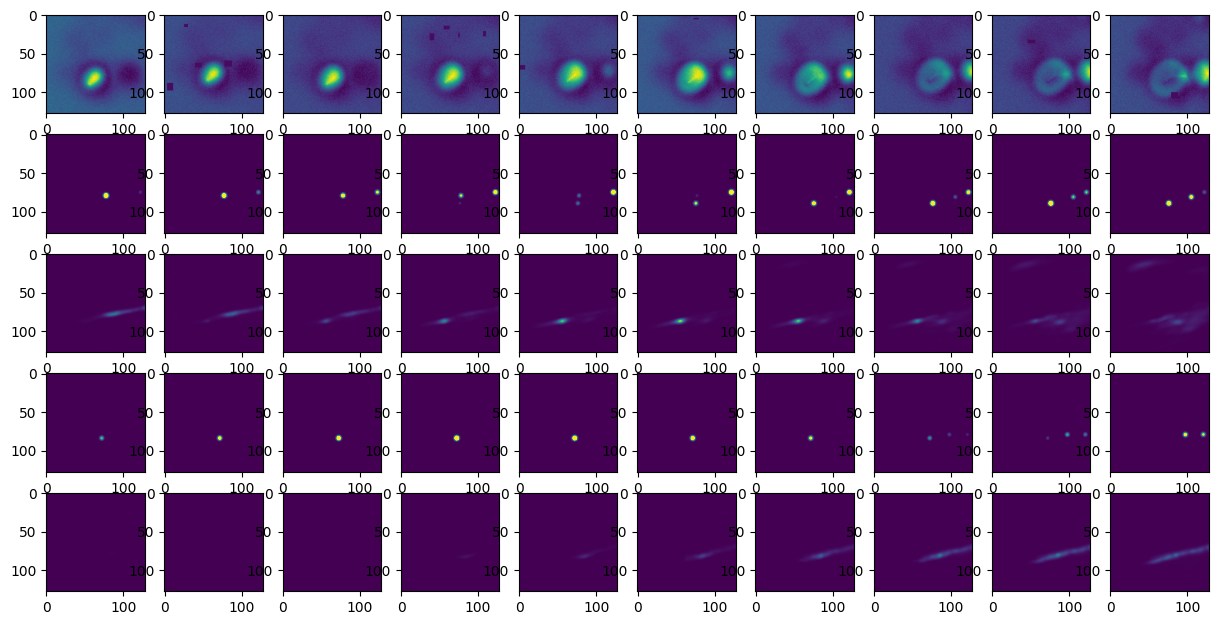

In [18]:
num_species = batch["atom_map"].shape[-1] * 2
num_heights = batch["atom_map"].shape[-2]
index = 2

fig = plt.figure(figsize=(num_heights*1.5, (1+num_species)*1.5))
for i in range(num_heights):
    ax = plt.subplot(num_species+1, num_heights, i + 1)
    ax.imshow(batch["images"][index, :, :, i, 0])

    ax = plt.subplot(num_species+1, num_heights, num_heights + i + 1)
    ax.imshow(batch["atom_map"][index, :, :, i, 0], vmin=0, vmax=1)

    ax = plt.subplot(num_species+1, num_heights, 2*num_heights + i + 1)
    ax.imshow(preds[index, :, :, i, 0], vmin=0, vmax=1)

    ax = plt.subplot(num_species+1, num_heights, 3*num_heights + i + 1)
    ax.imshow(batch["atom_map"][index, :, :, i, 1], vmin=0, vmax=1)

    ax = plt.subplot(num_species+1, num_heights, 4*num_heights + i + 1)
    ax.imshow(preds[index, :, :, i, 1], vmin=0, vmax=1)

        

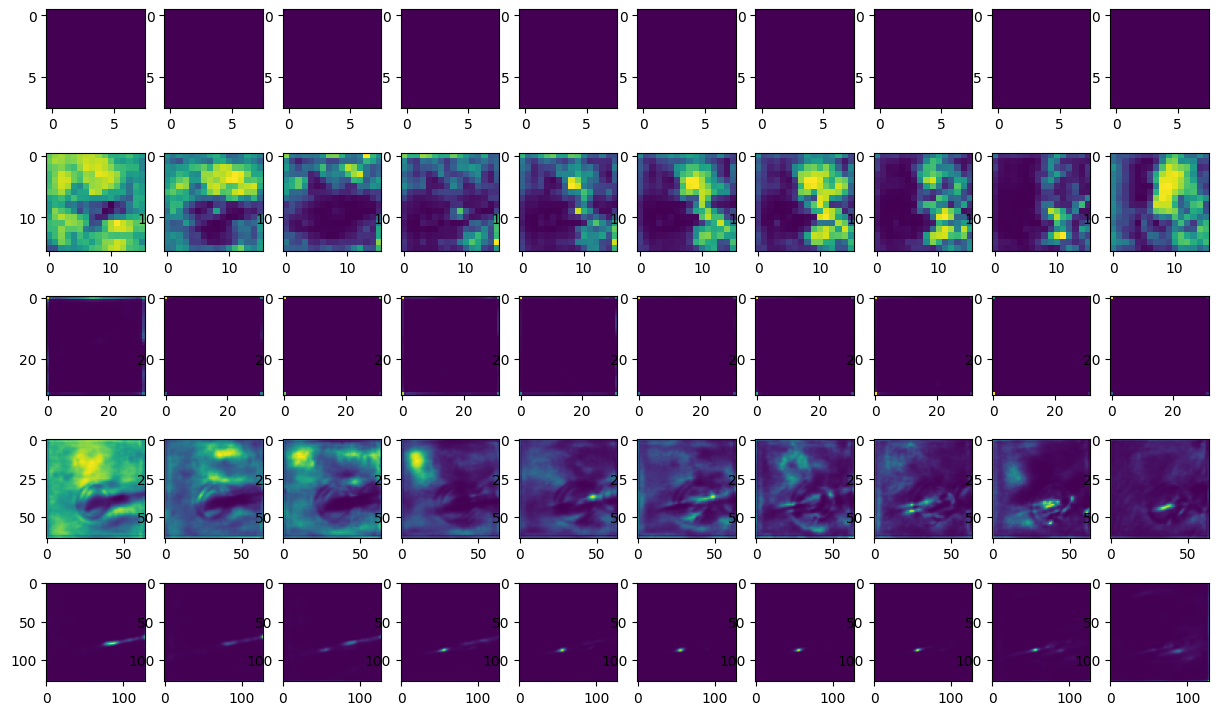

In [21]:
num_attentions = len(attention)

fig = plt.figure(figsize=(num_heights*1.5, (1+num_attentions)*1.5))

for i in range(num_heights):
    for j, att in enumerate(attention):
        # cast to float32 to avoid a bug in matplotlib
        att = att.astype(jnp.float32) 
        ax = plt.subplot(num_attentions, num_heights, j*num_heights + i + 1)
        ax.imshow(att[index, :, :, i, 0])